In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Using Divvy data

## Load and concat the Divvy datasets

In [ ]:
divvy1 = pd.read_csv('data/Divvy_Trips_2017_Q1Q2/Divvy_Trips_2017_Q1.csv', parse_dates=['start_time', 'end_time'])
divvy2 = pd.read_csv('data/Divvy_Trips_2017_Q1Q2/Divvy_Trips_2017_Q2.csv', parse_dates=['start_time', 'end_time'])
divvy3 = pd.read_csv('data/Divvy_Trips_2017_Q3Q4/Divvy_Trips_2017_Q3.csv', parse_dates=['start_time', 'end_time'])
divvy4 = pd.read_csv('data/Divvy_Trips_2017_Q3Q4/Divvy_Trips_2017_Q4.csv', parse_dates=['start_time', 'end_time'])

divvy = pd.concat([divvy1, divvy2, divvy3, divvy4], ignore_index=True)

divvy.to_csv('data/divvy_2017.csv', index=False)

In [ ]:
divvy = pd.read_csv('data/divvy_2017.csv')

In [ ]:
divvy

In [ ]:
station_list = set(list(divvy['from_station_name'].unique()) + list(divvy['to_station_name'].unique()))
station_list

In [ ]:
len(station_list)

## Load Divvy station info for GPS coordinates

In [ ]:
with open('data/stations.json') as json_data:
    station_data = json.load(json_data)

In [ ]:
station_data['stationBeanList']

In [ ]:
stations = [station['stationName'] for station in station_data['stationBeanList']]
latitude = [station['latitude'] for station in station_data['stationBeanList']]
longitude = [station['longitude'] for station in station_data['stationBeanList']]

In [ ]:
len(stations)

In [ ]:
unknown = []
for station in station_list:
    if station not in stations:
        unknown.append(station)
unknown

In [ ]:
station_gps = pd.DataFrame({'station_name': stations, 'latitude': latitude, 'longitude': longitude})

In [ ]:
station_gps.head()

In [ ]:
def gps_lookup(location):
    match = (station_gps['station_name'] == location)
    coord = station_gps['latitude'][match]
    if len(coord) > 0:
        return pd.Series([coord.values[0], station_gps['longitude'][match].values[0]])
    else:
        return pd.Series([np.nan, np.nan])

In [ ]:
divvy[['from_station_latitude', 'from_station_longitude']] = divvy['from_station_name'].apply(gps_lookup)
divvy[['to_station_latitude', 'to_station_longitude']] = divvy['to_station_name'].apply(gps_lookup)

In [ ]:
divvy

In [ ]:
divvy.to_csv('data/divvy_2017.csv', index=False)

In [111]:
divvy = pd.read_csv('data/divvy_2017.csv')

### 1) Top 5 stations with the most starts (showing # of starts)

In [ ]:
station_starts = divvy.groupby(['from_station_name'])['from_station_name'].count().sort_values(ascending=False)
station_starts.head()

In [ ]:
ax = station_starts.head(5).plot(kind='bar', figsize=(15, 10), title='Top 5 Stations with Most Starts')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + .15, p.get_height() * 1.005))

### 2) Trip duration by user type

In [ ]:
trip_duration = divvy.groupby(['usertype'])['tripduration'].mean().sort_values(ascending=False)
trip_duration

In [ ]:
ax = divvy.boxplot(column='tripduration', by='usertype', figsize=(15,10))

In [ ]:
ax = divvy.boxplot(column='tripduration', by='usertype', figsize=(15,10), showfliers=False)

### 3) Most popular trips based on start station and stop station

In [ ]:
divvy['trip_stations'] = divvy['from_station_name'] + ' TO ' + divvy['to_station_name']

In [ ]:
trip_stations = divvy.groupby(['trip_stations'])['trip_stations'].count().sort_values(ascending=False)
trip_stations.head()

In [ ]:
ax = trip_stations.head(10).plot(kind='bar', figsize=(15, 10), title='Top 10 Most Popular Trips')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + .05, p.get_height() * 1.005))

### Create dataframe of paths for Tableau chart

In [ ]:
trip_dict = {'path': list(trip_stations.index), 'frequency': list(trip_stations.values)}
trip_dict['origin'] = [x.split(' TO ')[0] for x in trip_dict['path']]
trip_dict['destination'] = [x.split(' TO ')[1] for x in trip_dict['path']]

In [ ]:
from collections import defaultdict

trips = defaultdict(list)

for idx in range(len(trip_dict['path'])):
    trips['path'].append(trip_dict['path'][idx])
    trips['frequency'].append(trip_dict['frequency'][idx])
    trips['origin-destination'].append('origin')
    trips['station'].append(trip_dict['origin'][idx])
    
    trips['path'].append(trip_dict['path'][idx])
    trips['frequency'].append(trip_dict['frequency'][idx])
    trips['origin-destination'].append('destination')
    trips['station'].append(trip_dict['destination'][idx])

In [ ]:
stations_gps = (divvy[divvy['from_station_name'].duplicated()]
                [['from_station_name', 'from_station_latitude', 'from_station_longitude']].reset_index(drop=True))

In [ ]:
trips_df = pd.DataFrame(trips).merge(stations_gps.drop_duplicates(subset=['from_station_name']),
                                     how='left',
                                     left_on='station',
                                     right_on='from_station_name')

In [ ]:
trips_df.drop(['from_station_name'], axis=1, inplace=True)

In [ ]:
trips_df.to_csv('data/divvy_trips.csv')

### 4) Rider performance by Gender and Age based on avg trip distance (station to station), median speed (distance traveled / trip duration)

Multiply geodesic distance by 1.25. Routes follow roads but the calculated route is direct (geodesic). A route straight down a road would be the same as the direct route; a route diagnoal to roads would be multiplied by 1.414 (thanks, Pythagoras!); assuming routes are evenly split between diagonal and direct, with some wiggle room, I'm splitting the difference at 1.25.

I looked at using the Google Maps api to calculate the actual, along-the-road distance, but they've removed the free api key option. I also looked at Bing Maps, but it's rate limited and I have more than 98,000 routes in this dataset (and once I saw how big that number was, I realized that using api calls would take more than a few days!). So I opted for this *x1.25* method which is less accurate but far quicker and cheaper.

In [ ]:
from math import isnan

def find_distance(row):
    if (not isnan(row['from_station_latitude']) and
        not isnan(row['from_station_longitude']) and
        not isnan(row['to_station_latitude']) and
        not isnan(row['to_station_longitude'])):
        return (1.25 * (geopy.distance.distance((row['from_station_latitude'], row['from_station_longitude']),
                                                (row['to_station_latitude'], row['to_station_longitude'])).m))
    return np.nan

In [ ]:
from math import isnan

def find_distance(row):
    if (not isnan(row['from_station_latitude']) and
        not isnan(row['from_station_longitude']) and
        not isnan(row['to_station_latitude']) and
        not isnan(row['to_station_longitude'])):
        distance = (1.25 * (geopy.distance.distance((row['from_station_latitude'], row['from_station_longitude']),
                                                (row['to_station_latitude'], row['to_station_longitude'])).m))
        print(distance)
        return distance
    else:
        print(np.nan)
    return np.nan

In [ ]:
divvy['trip_distance'] = divvy.apply(find_distance, axis=1)
divvy['speed'] = divvy['trip_distance'] / divvy['tripduration']

In [ ]:
divvy.to_csv('data/divvy_2017.csv')

In [ ]:
divvy = pd.read_csv('data/divvy_2017.csv')

# Yelp data

In [2]:
business = pd.read_json('data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)

checkin = pd.read_json('data/yelp_dataset/yelp_academic_dataset_checkin.json', lines=True)

max_records = 1e5
df = pd.read_json('data/yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=max_records)
review = pd.DataFrame() # Initialize the dataframe
try:
    for df_chunk in df:
        review = pd.concat([review, df_chunk])
except ValueError:
    print ('\nSome messages in the file cannot be parsed')

In [ ]:
business

In [99]:
checkin

,business_id,time,checkins
0,7KPBkxAOEtb3QeIL9PEErg,"{'Fri-0': 2, 'Sat-0': 1, 'Sun-0': 1, 'Wed-0': ...",151
1,kREVIrSBbtqBhIYkTccQUg,"{'Mon-13': 1, 'Thu-13': 1, 'Sat-16': 1, 'Wed-1...",7
2,tJRDll5yqpZwehenzE2cSg,"{'Thu-0': 1, 'Mon-1': 1, 'Mon-12': 1, 'Sat-16'...",6
3,tZccfdl6JNw-j5BKnCTIQQ,"{'Sun-14': 1, 'Fri-18': 1, 'Mon-20': 1}",3
4,r1p7RAMzCV_6NPF0dNoR3g,"{'Sat-3': 1, 'Sun-18': 1, 'Sat-21': 1, 'Sat-23...",5
5,OVkBMWxUBXGoO4K3_CeJ7g,"{'Sat-17': 1, 'Sat-18': 1}",2
6,fW1SKSunVnlaq-fxZ-gSUQ,"{'Sun-0': 1, 'Thu-0': 1, 'Sun-1': 1, 'Sat-15':...",29
7,mDdqgfrvROGAumcQdZ3HIg,"{'Fri-2': 1, 'Fri-11': 1, 'Thu-11': 3, 'Mon-12...",29
8,nhZ1HGWD8lMErdn3FuWuTQ,"{'Fri-0': 1, 'Sat-0': 1, 'Sun-0': 1, 'Thu-0': ...",47
9,vDoXZGE7p6xAkKQ0XQPvoA,"{'Thu-15': 1, 'Sat-23': 1}",2


In [ ]:
review

In [3]:
checkin['checkins'] = checkin['time'].apply(lambda x : sum(x.values()))
yelp = business.merge(checkin, on='business_id', how='outer')

In [ ]:
business.to_csv('data/yelp_business.csv', index=False)
checkin.to_csv('data/yelp_checkin.csv', index=False)
review.to_csv('data/yelp_review.csv', index=False)
yelp.to_csv('data/yelp.csv', index=False)

In [4]:
review['date'] = pd.to_datetime(review['date'])
review = review[review['date'].dt.year == 2017]

### Find the top 10 and bottom 10 restaurants in Illinois having most and least checkins respectively.

In [ ]:
yelp.head()

In [ ]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'].isnull()) &
         (yelp['is_open'] == 1)])

In [ ]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 1) &
         (yelp['is_open'] == 1)])

In [ ]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 2) &
         (yelp['is_open'] == 1)])

In [ ]:
len(yelp[(yelp['state'] == 'IL') &
         (yelp['categories'].str.contains('Restaurants')) &
         (yelp['checkins'] == 3) &
         (yelp['is_open'] == 1)])

In [5]:
top10 = yelp[(yelp['state'] == 'IL') &
             (yelp['categories'].str.contains('Restaurants') &
              (yelp['is_open'] == 1))
            ].sort_values('checkins', ascending=False).head(10)

bottom10 = yelp[(yelp['state'] == 'IL') &
                (yelp['categories'].str.contains('Restaurants') &
                (yelp['is_open'] == 1))
               ].sort_values('checkins', ascending=False).tail(30)

In [ ]:
top10

In [ ]:
bottom10

In [ ]:
top10.to_csv('data/yelp_top10_checkins.csv', index=False)
bottom10.to_csv('data/yelp_bottom10_checkins.csv', index=False)

In [6]:
top10_names = top10['name'].tolist()
top10_names

['Sakanaya',
 'Black Dog Smoke & Ale House',
 'DESTIHL Restaurant & Brew Works',
 'Seven Saints',
 'Golden Harbor Authentic Chinese Cuisine',
 'Maize Mexican Grill',
 'Meijer',
 'Cafe Kopi',
 'Courier Cafe',
 'Big Grove Tavern']

In [7]:
bottom10_names = bottom10['name'].tolist()
bottom10_names

['Monicals Pizza',
 'Subway',
 "McDonald's",
 'The Spice Box',
 'Subway',
 'Taco Bell',
 'Subway',
 'Asian Noodle and Sushi',
 'Red Cape Hot Pot',
 "McDonald's",
 'Main Street Belly Deli',
 'Subway',
 'Little Caesars Pizza',
 'Casa Real',
 'Tasty Fish Chicken & Grill',
 "J & J's Burgers & Beer",
 'Casa Del Mar',
 'Dairy Queen',
 'Nanjing Bistro',
 "Bergie's - The Occasional Place",
 'Sushi San',
 "Papa John's Pizza",
 "Domino's Pizza",
 'Golden Kitchen',
 'The Wild Hare',
 'Stango Cuisine',
 "Tortica's Grill",
 'Manzellas Italian Restaurant',
 "Jimmy John's",
 "Domino's Pizza"]

### For the top 10 and bottom 10 restaurants calculated in step 6, calculate the average star rating and average sentiment score of the reviews

In [8]:
top_bottom = top10['business_id'].tolist() + bottom10['business_id'].tolist()
top_bottom

['-zEpEmDfFQL-ph0N3BDlXA',
 '9MnbQg7kfb_WgxoV0hXKSQ',
 '-fiUXzkxRfbHY9TKWwuptw',
 'L2c-qKZWumCmOCR-dqBLrg',
 't_yiQnxUDdPPCN2z4QyezA',
 'VIJ2KiDKhUVhhpNylEIfog',
 'XbHxWOciYlBhJOjKRQbo9g',
 'e0prCZXtHGQIKeQ_wTW3uw',
 'o13eH93qmWVNFZogkjhd9w',
 'dn9lwYUxmhs_mLKPu7L25Q',
 'DLhAuWok29OU8VR-DBxP7A',
 'RDr-19q3FSDLezc_kJK88w',
 'n3AHTASqE5QCfuq0AQpT5Q',
 'fsBAaw7xwHWB78HRSWwQEQ',
 'ZjJzuxjpOTAPWTFbaX06ew',
 'hH7qhup_bGKr9r27RpHJPw',
 'zaoGcD35rSuuAwc7DLiSMw',
 'hz18cj0wMLa5X9GVW-Un9A',
 'ZvSy8yaly9Aeh64Qm4Dsfw',
 'AZRREnqWvjnL4VqSovXHcA',
 'IFlSq9YWXHZyLnuh0EffKQ',
 'N9osJe0lQOdnd3xLUkJVMw',
 'ks6JgGsz7phkGEVh9hoHkg',
 'AW_d5hMf7sI6yHrz4Ujv8w',
 '62Ibju8UmUZtPIBLDS_nUw',
 'KkpX5EdixY0C5gUq8BcmCA',
 'LvPbZ_5odnjE_oj5BNHivQ',
 'sDfN5qJlmvrwTfwEPBsxSg',
 'Hc5NrzzzL8RAnbcrIAvZug',
 'VhgHIT3Krb278n5RcPXVsg',
 'IYASJOu_TXz8PpPbt-Clbg',
 '83_gVj7cnJd0-J5ZoYN9qA',
 '3XUH9aFxt4vU9Pzi5aBtow',
 'W7KtVjq4R_5F5EwbCBENQw',
 '21UO0mP1EgEDZyFUFFI9Mg',
 '-yZ78Hd2DKDqvxJKbCyELg',
 'Pq_dAtQ4i1wkyWsEiFYrEA',
 

In [9]:
sentiment = review[review['business_id'].isin(top_bottom)]

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_vader_scores(text):
    '''
    Takes a string of text and outputs four values for Vader's negative,
    neutral, positive, and compound (normalized) sentiment scores
    INPUT: a string
    OUTPUT: a dictionary of four sentiment scores
    '''

    analyser = SentimentIntensityAnalyzer()
    return analyser.polarity_scores(text)


def apply_vader(df, column):
    '''
    Takes a DataFrame with a specified column of text and adds four new columns
    to the DataFrame, corresponding to the Vader sentiment scores
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with four additional columns
    '''

    sentiment = pd.DataFrame(df[column].apply(get_vader_scores))
    unpacked = pd.DataFrame([d for idx, d in sentiment['text'].iteritems()],
                            index=sentiment.index)
    unpacked['compound'] += 1
    columns = {'neu': 'v_neutral', 'pos': 'v_positive', 'neg': 'v_negative'}
    unpacked.rename(columns=columns, inplace=True)
    return pd.concat([df, unpacked], axis=1)

In [11]:
sentiment = apply_vader(sentiment, 'text')

In [ ]:
sentiment

In [12]:
top10_sentiment = {}
for biz_id in top10['business_id'].tolist():
    top10_sentiment[yelp.loc[yelp['business_id'] == biz_id, 'name'].iloc[0]] = sentiment[sentiment['business_id'] == biz_id].groupby(['business_id']).mean()

In [13]:
top10_scores = pd.DataFrame()
for restaurant in top10_sentiment:
    top10_scores = top10_scores.append(pd.DataFrame(top10_sentiment[restaurant]))
top10_scores.reset_index(level=0, inplace=True)

In [14]:
top10_scores['name'] = top10_scores['business_id'].apply(lambda business_id: yelp['name']
                                                         [(yelp['business_id'] == business_id)].values[0])

In [ ]:
top10_scores

In [15]:
bottom10_sentiment = {}
for biz_id in bottom10['business_id'].tolist():
    bottom10_sentiment[yelp.loc[yelp['business_id'] == biz_id, 'name'].iloc[0]] = sentiment[sentiment['business_id'] == biz_id].groupby(['business_id']).mean()

In [16]:
bottom10_scores = pd.DataFrame()
for restaurant in bottom10_sentiment:
    bottom10_scores = bottom10_scores.append(pd.DataFrame(bottom10_sentiment[restaurant]))
bottom10_scores.reset_index(level=0, inplace=True)

In [17]:
bottom10_scores['name'] = bottom10_scores['business_id'].apply(lambda business_id: yelp['name']
                                                               [(yelp['business_id'] == business_id)].values[0])

In [ ]:
bottom10_scores

In [ ]:
top10_scores.to_csv('data/yelp_top_scores.csv', index=False)
bottom10_scores.to_csv('data/yelp_bottom_scores.csv', index=False)

### What are the top 10 Cuisine types (Mexican, American, Thai, etc) based on the number of restaurants and number of check ins

In [18]:
restaurants = yelp[yelp['categories'].str.contains('Restaurants', na=False)]

In [19]:
pd.options.mode.chained_assignment = None  # default='warn'
restaurants['categories'] = restaurants['categories'].apply(lambda x: x.split(', '))

In [20]:
restaurants = restaurants.join(pd.get_dummies(pd.DataFrame(restaurants['categories'].tolist()).stack()).astype(int).sum(level=0))

In [21]:
columns = [item for item in restaurants.columns.tolist() if item not in yelp.columns.tolist()]
columns.remove('Restaurants')

In [22]:
num_restaurants = restaurants[columns].sum(numeric_only=True).sort_values(ascending=False)
num_restaurants

Food                                3607.0
Nightlife                           2399.0
Bars                                2313.0
Sandwiches                          2166.0
Pizza                               2139.0
Fast Food                           2089.0
American (Traditional)              2083.0
Breakfast & Brunch                  1566.0
Burgers                             1558.0
Italian                             1384.0
Mexican                             1335.0
American (New)                      1308.0
Chinese                             1265.0
Coffee & Tea                         992.0
Cafes                                955.0
Chicken Wings                        809.0
Japanese                             794.0
Salad                                736.0
Seafood                              714.0
Event Planning & Services            655.0
Sushi Bars                           641.0
Canadian (New)                       614.0
Delis                                591.0
Mediterrane

In [23]:
checkin_dict ={}
for item in columns:
    cnt = restaurants[restaurants[item] == 1].groupby([item])['checkins'].sum()
    if cnt.empty:
        checkin_dict[item] = 0
    else:
        checkin_dict[item] = restaurants[restaurants[item] == 1].groupby([item])['checkins'].sum().values[0]

In [24]:
checkin_dict = pd.Series(checkin_dict).sort_values(ascending=False)

In [ ]:
checkin_dict

In [25]:
for item in checkin_dict.keys():
    print(item)

Food
Nightlife
Bars
Sandwiches
Pizza
Fast Food
American (Traditional)
Breakfast & Brunch
Mexican
Burgers
Chinese
Italian
American (New)
Coffee & Tea
Chicken Wings
Japanese
Cafes
Event Planning & Services
Salad
Thai
Seafood
Specialty Food
Canadian (New)
Sports Bars
Sushi Bars
Caterers
Steakhouses
Pubs
Barbeque
Delis
Desserts
Mediterranean
Asian Fusion
Bakeries
Indian
Beer
Wine & Spirits
Diners
Buffets
Korean
Lounges
Greek
Wine Bars
Cocktail Bars
Vegetarian
Middle Eastern
Gluten-Free
Vietnamese
Soup
French
Ethnic Food
Juice Bars & Smoothies
Comfort Food
Food Trucks
Hot Dogs
Tex-Mex
Gastropubs
Caribbean
Arts & Entertainment
Grocery
Vegan
Food Delivery Services
Ice Cream & Frozen Yogurt
Latin American
Noodles
Food Stands
Chicken Shop
Shopping
Venues & Event Spaces
Tapas Bars
Irish
Bagels
Tapas/Small Plates
Southern
Halal
Breweries
Pakistani
Hawaiian
Ramen
Creperies
Music Venues
Poutineries
Hotels & Travel
Fish & Chips
Health Markets
Party & Event Planning
Dance Clubs
Imported Food
Cajun/Cr

In [ ]:
pd.DataFrame(checkin_dict).to_csv('data/yelp_cuisine_checkin.csv', index=False)
pd.DataFrame(num_restaurants).to_csv('data/yelp_cuisine_restaurants.csv', index=False)

### What are the most popular keywords or adjectives that reviewers use for the above list of cuisines (calculated in step 8)

In [26]:
cuisine_list = ['American (Traditional)', 'Mexican', 'Chinese', 'Italian', 'American (New)',
               'Japanese', 'Thai', 'Mediterranean', 'Asian Fusion', 'Indian', 'Korean',
                'Greek', 'Middle Eastern', 'Vietnamese', 'French', 'Tex-Mex', 'Caribbean']
cuisines = pd.DataFrame()
for cuisine in cuisine_list:
    businesses = yelp[yelp['categories'].str.contains(cuisine, na=False)]['business_id'].tolist()
    temp = review[review['business_id'].isin(businesses)]
    temp['cuisine'] = cuisine
    cuisines = pd.concat([cuisines, temp], ignore_index=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [ ]:
cuisines

In [34]:
import spacy
from collections import Counter

nlp = spacy.load('en')

nlp.max_length = 1500000

In [35]:
cuisine_docs = {}

for cuisine in cuisine_list:
    print()
    print(cuisine)
    text = cuisines[cuisines['cuisine'] == cuisine]['text'].str.cat(sep=' ')
    chunk_size = 1000000
    num_chunks = len(text) // chunk_size + 1
    
    words = []
    adj = []
    
    for chunk in range(num_chunks):
        print('  chunk', chunk + 1, 'of', num_chunks)
        chunk_start = chunk_size * (chunk - 1)
        chunk_end = chunk_size * chunk
        chunk_text = text[chunk_start: chunk_end]
    
        doc = nlp(chunk_text)
        # all tokens that arent stop words or punctuations
        words.extend([token.text for token in doc if
                      token.is_stop !=True and token.is_punct != True])

        # adjective tokens that arent stop words or punctuations
        adj.extend([token.text for token in doc if
                    token.is_stop != True and
                    token.is_punct != True and token.pos_ == "ADJ"])

    # 200 most common tokens
    word_freq = Counter(words)
    common_words = word_freq.most_common(200)

    # five most common adjective tokens
    adj_freq = Counter(adj)
    common_adj = adj_freq.most_common(200)
    
    cuisine_docs[cuisine] = {'words': words,
                               'adj': adj,
                               'common_words': common_words,
                               'common_adj': common_adj}

American (Traditional)
chunk 1 of 1
Mexican
chunk 1 of 34
chunk 2 of 34
chunk 3 of 34
chunk 4 of 34
chunk 5 of 34
chunk 6 of 34
chunk 7 of 34
chunk 8 of 34
chunk 9 of 34
chunk 10 of 34
chunk 11 of 34
chunk 12 of 34
chunk 13 of 34
chunk 14 of 34
chunk 15 of 34
chunk 16 of 34
chunk 17 of 34
chunk 18 of 34
chunk 19 of 34
chunk 20 of 34
chunk 21 of 34
chunk 22 of 34
chunk 23 of 34
chunk 24 of 34
chunk 25 of 34
chunk 26 of 34
chunk 27 of 34
chunk 28 of 34
chunk 29 of 34
chunk 30 of 34
chunk 31 of 34
chunk 32 of 34
chunk 33 of 34
chunk 34 of 34
Chinese
chunk 1 of 24
chunk 2 of 24
chunk 3 of 24
chunk 4 of 24
chunk 5 of 24
chunk 6 of 24
chunk 7 of 24
chunk 8 of 24
chunk 9 of 24
chunk 10 of 24
chunk 11 of 24
chunk 12 of 24
chunk 13 of 24
chunk 14 of 24
chunk 15 of 24
chunk 16 of 24
chunk 17 of 24
chunk 18 of 24
chunk 19 of 24
chunk 20 of 24
chunk 21 of 24
chunk 22 of 24
chunk 23 of 24
chunk 24 of 24
Italian
chunk 1 of 33
chunk 2 of 33
chunk 3 of 33
chunk 4 of 33
chunk 5 of 33
chunk 6 of 33
chun

In [98]:
for cuisine in cuisine_docs.keys():
    with open('data/yelp_cuisine_' + cuisine + '.json', 'w') as fp:
        json.dump(cuisine_docs[cuisine], fp)

In [90]:
cuisine_df = pd.DataFrame()

for cuisine in cuisine_docs.keys():
    temp = pd.DataFrame({'words': ' '.join(cuisine_docs[cuisine]['words']).replace('\n', ' ').replace('\r', ''),
                         'adj': ' '.join(cuisine_docs[cuisine]['adj']).replace('\n', ' ').replace('\r', ''),
                         'common_words': [cuisine_docs[cuisine]['common_words']],
                         'common_adj': [cuisine_docs[cuisine]['common_adj']]})
    temp['cuisine'] = cuisine
    cuisine_df = pd.concat([cuisine_df, temp], ignore_index=True)

In [92]:
cuisine_df.to_csv('data/yelp_cuisine_words.csv', index=False)

### Download weather data from Weather Underground (but free API access has ended!)

In [ ]:
# Query data in different years
# You can get keys from https://www.wunderground.com/
keys = ['***************', '***************', '***************', 
        '***************', '***************']
years = [2017]

for key, year in zip(keys, years):
    path = './data/weather_' + str(year) + '.csv'
    if os.path.isfile(path):
        continue
    df, _ = query_weather(key=key, year=year, state='IL', area='Chicago')
    df.to_csv(path, index=False)
    print('File saved:\t', path)

### or, just join the Kaggle dataset

In [108]:
divvy_kaggle = pd.read_csv('data/chicago-divvy-bicycle-sharing-data/data_raw.csv', parse_dates=['starttime', 'stoptime'])

In [109]:
divvy_kaggle = divvy_kaggle[divvy_kaggle['starttime'].dt.year == 2017].reset_index(drop=True)

In [ ]:
# divvy_kaggle.to_csv('data/divvy_2017_kaggle.csv')

In [ ]:
divvy_kaggle = pd.read_csv('data/divvy_2017_kaggle.csv')

In [110]:
divvy_kaggle.columns

Index(['trip_id', 'usertype', 'gender', 'starttime', 'stoptime',
       'tripduration', 'from_station_id', 'from_station_name',
       'latitude_start', 'longitude_start', 'dpcapacity_start',
       'to_station_id', 'to_station_name', 'latitude_end', 'longitude_end',
       'dpcapacity_end', 'temperature', 'windchill', 'dewpoint', 'humidity',
       'pressure', 'visibility', 'wind_speed', 'precipitation', 'events',
       'rain', 'conditions'],
      dtype='object')

In [232]:
divvy.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear',
       'from_station_latitude', 'from_station_longitude',
       'to_station_latitude', 'to_station_longitude', 'trip_distance',
       'speed'],
      dtype='object')

In [113]:
len(divvy_kaggle)

3826746

In [114]:
len(divvy)

3829014

In [233]:
df = divvy.merge(divvy_kaggle[['trip_id', 'temperature', 'windchill',
                               'dewpoint', 'humidity', 'pressure',
                               'visibility', 'wind_speed',
                               'precipitation', 'events',
                               'rain', 'conditions']], on='trip_id', how='inner')

In [234]:
df.dropna(inplace=True)
df = df[(df['tripduration'] <= 3600) & (df['trip_distance'] >= 200)]

In [235]:
df.to_csv('data/divvy_weather.csv', index=False)

In [236]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear',
       'from_station_latitude', 'from_station_longitude',
       'to_station_latitude', 'to_station_longitude', 'trip_distance', 'speed',
       'temperature', 'windchill', 'dewpoint', 'humidity', 'pressure',
       'visibility', 'wind_speed', 'precipitation', 'events', 'rain',
       'conditions'],
      dtype='object')

In [237]:
df.head()

,Unnamed: 0,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,...,windchill,dewpoint,humidity,pressure,visibility,wind_speed,precipitation,events,rain,conditions
0,0,13518905,2017-03-31 23:59:07,2017-04-01 00:13:24,5292,857,66,Clinton St & Lake St,171,May St & Cullerton St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
1,1,13518904,2017-03-31 23:56:25,2017-04-01 00:00:21,4408,236,199,Wabash Ave & Grand Ave,26,McClurg Ct & Illinois St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
2,2,13518903,2017-03-31 23:55:33,2017-04-01 00:01:21,696,348,520,Greenview Ave & Jarvis Ave,432,Clark St & Lunt Ave,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
3,3,13518902,2017-03-31 23:54:46,2017-03-31 23:59:34,4915,288,110,Dearborn St & Erie St,142,McClurg Ct & Erie St,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy
5,5,13518900,2017-03-31 23:51:17,2017-03-31 23:55:19,3536,242,143,Sedgwick St & Webster Ave,289,Wells St & Concord Ln,...,32.1,30.9,76.0,30.05,10.0,8.1,-9999.0,partlycloudy,0,Partly Cloudy


In [238]:
df['start_time'] = pd.to_datetime(df['start_time'])

In [239]:
df['day'] = df['start_time'].dt.dayofweek
df['month'] = df['start_time'].dt.month

In [240]:
df = pd.get_dummies(df, columns=['day'])
df = pd.get_dummies(df, columns=['month'])
df = pd.get_dummies(df, columns=['usertype'])
df = pd.get_dummies(df, columns=['events'])
df = pd.get_dummies(df, columns=['conditions'])

### Chicago rush hours: https://www.illinoisvehicle.com/about-us/blog/traffic-patterns-chicago/

In [241]:
df['morning_rush_hour'] = np.where(((df['start_time'].dt.hour > 6) &
                                    (df['start_time'].dt.hour < 10)),
                                    1, 0)

df['evening_rush_hour'] = np.where(((df['start_time'].dt.hour > 15) &
                                    (df['start_time'].dt.hour < 19)),
                                    1, 0)

df['night'] = np.where(((df['start_time'].dt.hour <= 19) &
                        (df['start_time'].dt.hour <= 6)),
                         1, 0)

df['midday'] = np.where(((df['start_time'].dt.hour >= 10) &
                         (df['start_time'].dt.hour <= 15)),
                         1, 0)

In [242]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'start_time', 'end_time', 'bikeid',
       'tripduration', 'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'gender', 'birthyear', 'from_station_latitude',
       'from_station_longitude', 'to_station_latitude', 'to_station_longitude',
       'trip_distance', 'speed', 'temperature', 'windchill', 'dewpoint',
       'humidity', 'pressure', 'visibility', 'wind_speed', 'precipitation',
       'rain', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'usertype_Customer', 'usertype_Dependent', 'usertype_Subscriber',
       'events_clear', 'events_cloudy', 'events_fog', 'events_hazy',
       'events_mostlycloudy', 'events_partlycloudy', 'events_rain',
       'events_sleet', 'events_snow', 'events_tstorms', 'conditions_Clear',
       'conditions_Drizzle', 'condit

In [243]:
from sklearn.linear_model import LinearRegression

In [244]:
columns = ['trip_distance', 'temperature', 'windchill', 'dewpoint',
           'humidity', 'pressure', 'visibility', 'wind_speed', 'precipitation',
           'rain', 'morning_rush_hour',
           'evening_rush_hour', 'night', 'midday', 'day_0', 'day_1', 'day_2',
           'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3',
           'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
           'month_10', 'month_11', 'month_12', 'usertype_Customer',
           'usertype_Dependent', 'usertype_Subscriber',
           'events_clear', 'events_cloudy', 'events_fog', 'events_hazy',
           'events_mostlycloudy', 'events_partlycloudy', 'events_rain',
           'events_sleet', 'events_snow', 'events_tstorms', 'conditions_Clear',
           'conditions_Drizzle', 'conditions_Fog', 'conditions_Freezing Rain',
           'conditions_Haze', 'conditions_Heavy Rain',
           'conditions_Heavy Thunderstorms and Rain', 'conditions_Light Drizzle',
           'conditions_Light Freezing Drizzle', 'conditions_Light Freezing Rain',
           'conditions_Light Hail', 'conditions_Light Rain',
           'conditions_Light Snow', 'conditions_Light Thunderstorms and Rain',
           'conditions_Mist', 'conditions_Mostly Cloudy', 'conditions_Overcast',
           'conditions_Partly Cloudy', 'conditions_Rain',
           'conditions_Scattered Clouds', 'conditions_Smoke', 'conditions_Snow',
           'conditions_Thunderstorm', 'conditions_Thunderstorms and Rain']

In [245]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[columns],
                                                    df['tripduration'],
                                                    test_size=0.2, random_state=0)

In [246]:
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6953257725558466

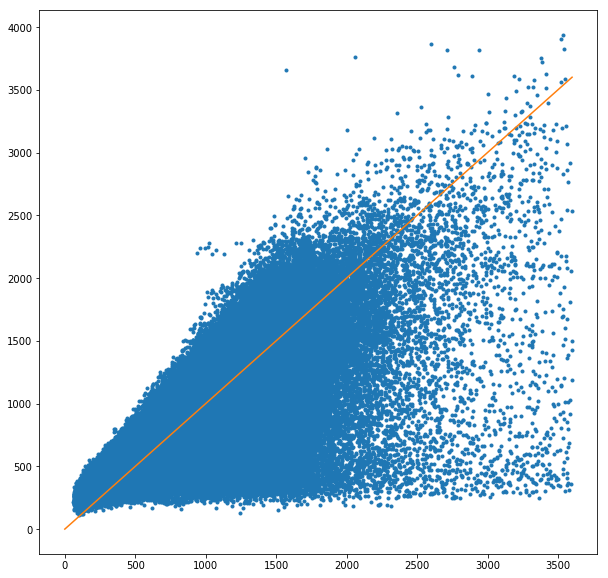

In [252]:
# plot prediction and actual data
y_pred = model.predict(X_test) 
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred, '.')

# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 3600, 4000)
y = x
plt.plot(x, y)
plt.show()

## Improvements:
Use the Google Maps API (https://developers.google.com/maps/documentation/distance-matrix/intro) to extract routes from the origin and destination, improving upon the straight-line distance. But hey, while we're at it, the API also outputs estimated trip duration which is exactly what we're looking for! Unfortuately, Google recently cut off free access to the API. It now costs $0.005 per query.

In [ ]:
cuisines_sample = cuisines
# cuisines_sample = cuisines.sample(frac=0.025)